## HOMEWORK 4 - HPC

### 1. Import and Install Required Packages

In [1]:
import socket
import psutil
import torch
import platform
from datetime import datetime

print("="*60)
print("COMPUTE NODE INFORMATION")
print("="*60)
print(f"Node Name: {socket.gethostname()}")
print(f"Number of CPUs (Logical): {psutil.cpu_count(logical=True)}")
print(f"Number of CPUs (Physical): {psutil.cpu_count(logical=False)}")
print(f"CPU Model: {platform.processor()}")
print(f"Total Memory: {psutil.virtual_memory().total / (1024**3):.2f} GB")
print(f"Available Memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")
print(f"Python Version: {platform.python_version()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

COMPUTE NODE INFORMATION
Node Name: c0598
Number of CPUs (Logical): 28
Number of CPUs (Physical): 28
CPU Model: x86_64
Total Memory: 251.16 GB
Available Memory: 242.63 GB
Python Version: 3.12.4
PyTorch Version: 2.9.1+cu128
Execution Time: 2025-11-23 21:00:42


In [2]:
import sys
print("Installing required packages...")
!{sys.executable} -m pip install torchvision psutil matplotlib --quiet
print("✓ Packages installed successfully!")

Installing required packages...
✓ Packages installed successfully!


### 2. Create Model and Common Train Test Function .py file

In [3]:
%%writefile common.py
"""
Common components for MNIST distributed training
Contains: Model, train, test, setup, cleanup functions
"""

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist

# Set environment variables
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['OMP_NUM_THREADS'] = '1'


def setup(rank, world_size):
    """Initialize distributed training"""
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("gloo", rank=rank, world_size=world_size)


def cleanup():
    """Clean up distributed training"""
    dist.destroy_process_group()


class Net(nn.Module):
    """Simple CNN for MNIST"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, rank, world_size, train_loader, optimizer, epoch, sampler=None):
    """Training function for distributed training"""
    model.train()
    ddp_loss = torch.zeros(2)
    if sampler:
        sampler.set_epoch(epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        ddp_loss[0] += loss.item()
        ddp_loss[1] += len(data)
    
    dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)
    if rank == 0:
        print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, ddp_loss[0] / ddp_loss[1]))


def test(model, rank, world_size, test_loader):
    """Testing function for distributed training"""
    model.eval()
    ddp_loss = torch.zeros(3)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            ddp_loss[0] += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            ddp_loss[1] += pred.eq(target.view_as(pred)).sum().item()
            ddp_loss[2] += len(data)
    
    dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)
    
    if rank == 0:
        test_loss = (ddp_loss[0] / ddp_loss[2]).item()
        accuracy = (100. * ddp_loss[1] / ddp_loss[2]).item()
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, int(ddp_loss[1].item()), int(ddp_loss[2].item()), accuracy))
        return test_loss, accuracy
    return 0.0, 0.0

Writing common.py


### 3. DDP Training !

In [4]:
%%writefile ddp_training.py
"""
DDP (Distributed Data Parallel) Training Script
"""

import argparse
import time
import json
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist

from common import Net, setup, cleanup, train, test

import warnings
warnings.filterwarnings('ignore')


def ddp_main(rank, world_size, args):
    """DDP training function"""
    setup(rank, world_size)
    
    if rank == 0:
        print(f"\n[DDP] Starting training on {world_size} CPUs")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    if rank == 0:
        datasets.MNIST('./data', train=True, download=True, transform=transform)
        datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    dist.barrier()
    
    dataset1 = datasets.MNIST('./data', train=True, download=False, transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, download=False, transform=transform)
    
    sampler1 = DistributedSampler(dataset1, rank=rank, num_replicas=world_size, shuffle=True)
    sampler2 = DistributedSampler(dataset2, rank=rank, num_replicas=world_size)
    
    train_kwargs = {'batch_size': args.batch_size, 'sampler': sampler1}
    test_kwargs = {'batch_size': args.test_batch_size, 'sampler': sampler2}
    cpu_kwargs = {'num_workers': 0, 'pin_memory': False, 'shuffle': False}
    train_kwargs.update(cpu_kwargs)
    test_kwargs.update(cpu_kwargs)
    
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    
    model = Net()
    model = DDP(model)
    
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    
    init_start_time = time.time()
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, rank, world_size, train_loader, optimizer, epoch, sampler=sampler1)
        test_loss, test_acc = test(model, rank, world_size, test_loader)
        scheduler.step()
    
    init_end_time = time.time()
    
    if rank == 0:
        elapsed_time = init_end_time - init_start_time
        print(f"\n{'='*60}")
        print(f"DDP Training Complete")
        print(f"Total elapsed time: {elapsed_time:.2f} seconds")
        print(f"Final Test Accuracy: {test_acc:.2f}%")
        print(f"{'='*60}\n")
        
        with open('ddp_results.json', 'w') as f:
            json.dump({
                'method': 'DDP',
                'time': elapsed_time,
                'accuracy': test_acc,
                'world_size': world_size,
                'epochs': args.epochs
            }, f, indent=2)
    
    cleanup()


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='DDP Training')
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--test-batch-size', type=int, default=1000)
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--lr', type=float, default=1.0)
    parser.add_argument('--gamma', type=float, default=0.7)
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--world-size', type=int, default=4)
    
    args = parser.parse_args()
    torch.manual_seed(args.seed)
    
    print(f"Running DDP with {args.world_size} CPUs, {args.epochs} epochs")
    mp.spawn(ddp_main, args=(args.world_size, args), nprocs=args.world_size, join=True)

Writing ddp_training.py


### 4. FSDP2 Training !!

In [5]:
%%writefile fsdp2_training.py
"""
FSDP2 (Fully Sharded Data Parallel) Training Script
Uses loop-based layer wrapping pattern
"""

import argparse
import time
import json
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
from torch.distributed.fsdp import fully_shard

from common import Net, setup, cleanup, train, test

import warnings
warnings.filterwarnings('ignore')


def fsdp2_main(rank, world_size, args):
    """FSDP2 training function with loop-based layer wrapping"""
    setup(rank, world_size)
    
    if rank == 0:
        print(f"\n[FSDP2] Starting training on {world_size} CPUs")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    if rank == 0:
        datasets.MNIST('./data', train=True, download=True, transform=transform)
        datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    dist.barrier()
    
    dataset1 = datasets.MNIST('./data', train=True, download=False, transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, download=False, transform=transform)
    
    sampler1 = DistributedSampler(dataset1, rank=rank, num_replicas=world_size, shuffle=True)
    sampler2 = DistributedSampler(dataset2, rank=rank, num_replicas=world_size)
    
    train_kwargs = {'batch_size': args.batch_size, 'sampler': sampler1}
    test_kwargs = {'batch_size': args.test_batch_size, 'sampler': sampler2}
    cpu_kwargs = {'num_workers': 0, 'pin_memory': False, 'shuffle': False}
    train_kwargs.update(cpu_kwargs)
    test_kwargs.update(cpu_kwargs)
    
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    
    # FSDP2: Loop-based layer wrapping pattern
    model = Net()
    
    # Define layers to wrap
    layers_to_wrap = ['conv1', 'conv2', 'fc1', 'fc2']
    
    if rank == 0:
        print(f"[FSDP2] Applying loop-based wrapping to {len(layers_to_wrap)} layers...")
    
    # Loop through and wrap each layer (Transformer-style pattern)
    for layer_name in layers_to_wrap:
        layer = getattr(model, layer_name)
        setattr(model, layer_name, fully_shard(layer))
        if rank == 0:
            print(f"[FSDP2]   ✓ {layer_name} wrapped")
    
    # Wrap the entire model
    model = fully_shard(model)
    
    if rank == 0:
        print(f"[FSDP2]   ✓ Full model wrapped")
    
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    
    init_start_time = time.time()
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, rank, world_size, train_loader, optimizer, epoch, sampler=sampler1)
        test_loss, test_acc = test(model, rank, world_size, test_loader)
        scheduler.step()
    
    init_end_time = time.time()
    
    if rank == 0:
        elapsed_time = init_end_time - init_start_time
        print(f"\n{'='*60}")
        print(f"FSDP2 Training Complete")
        print(f"Wrapping Pattern: Loop-based layer wrapping")
        print(f"Layers wrapped: {', '.join(layers_to_wrap)} + full model")
        print(f"Total elapsed time: {elapsed_time:.2f} seconds")
        print(f"Final Test Accuracy: {test_acc:.2f}%")
        print(f"{'='*60}\n")
        
        with open('fsdp2_results.json', 'w') as f:
            json.dump({
                'method': 'FSDP2',
                'time': elapsed_time,
                'accuracy': test_acc,
                'world_size': world_size,
                'epochs': args.epochs,
                'wrapping_policy': f'loop-based: {", ".join(layers_to_wrap)} + full model',
                'layers_wrapped': layers_to_wrap
            }, f, indent=2)
    
    cleanup()


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='FSDP2 Training')
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--test-batch-size', type=int, default=1000)
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--lr', type=float, default=1.0)
    parser.add_argument('--gamma', type=float, default=0.7)
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--world-size', type=int, default=4)
    
    args = parser.parse_args()
    torch.manual_seed(args.seed)
    
    print(f"Running FSDP2 with {args.world_size} CPUs, {args.epochs} epochs")
    mp.spawn(fsdp2_main, args=(args.world_size, args), nprocs=args.world_size, join=True)

Writing fsdp2_training.py


### 5. Single CPU Baseline Training!

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import time

# Import model from common
from common import Net

def train_single_cpu(epochs=2):
    """Single CPU baseline for speedup comparison"""
    print("\n" + "="*60)
    print("SINGLE CPU BASELINE TRAINING")
    print("="*60)
    
    torch.manual_seed(42)
    
    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, num_workers=0
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1000, shuffle=False, num_workers=0
    )
    
    # Model setup
    model = Net()
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    
    # Training
    start_time = time.perf_counter()
    
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
        # Test
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Epoch {epoch}: Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
        scheduler.step()
    
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    
    print(f"\n✅ Single CPU Training Time: {elapsed_time:.2f} seconds")
    print(f"✅ Final Accuracy: {accuracy:.2f}%")
    
    # Save baseline results
    import json
    with open('baseline_results.json', 'w') as f:
        json.dump({
            'method': 'Single CPU',
            'time': elapsed_time,
            'accuracy': accuracy,
            'world_size': 1,
            'epochs': epochs
        }, f, indent=2)
    
    return elapsed_time, accuracy

# Run baseline
baseline_time, baseline_accuracy = train_single_cpu(epochs=5)


SINGLE CPU BASELINE TRAINING
Epoch 1: Loss: 0.0461, Accuracy: 98.43%
Epoch 2: Loss: 0.0407, Accuracy: 98.70%
Epoch 3: Loss: 0.0322, Accuracy: 99.00%
Epoch 4: Loss: 0.0321, Accuracy: 99.01%
Epoch 5: Loss: 0.0300, Accuracy: 99.11%

✅ Single CPU Training Time: 225.13 seconds
✅ Final Accuracy: 99.11%


### 6a. 2 CPU DDP Training Time 

In [7]:
print("\n🚀 Running DDP Training with 2 CPUs...\n")
!python ddp_training.py --world-size 2 --epochs 5


🚀 Running DDP Training with 2 CPUs...

Running DDP with 2 CPUs, 5 epochs
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11


[DDP] Starting training on 2 CPUs
Train Epoch: 1 	Loss: 0.225567
Test set: Average loss: 0.0480, Accuracy: 9847/10000 (98.47%)

Train Epoch: 2 	Loss: 0.072309
Test set: Average loss: 0.0382, Accuracy: 9884/10000 (98.84%)

Train Epoch: 3 	Loss: 0.054196
Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

Train Epoch: 4 	Loss: 0.044521
Test set: Average loss: 0.0292, Accuracy: 9903/10000 (99.03%)

Train Epoch: 5 	Loss: 0.039106
Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)


DDP Training Complete
Total elapsed time: 381.90 seconds
Final Test Accuracy: 99.18%



### 6b. 2 CPU FSDP2 Training Time 

In [8]:
print("\n🚀 Running FSDP2 Training with 2 CPUs...\n")
!python fsdp2_training.py --world-size 2 --epochs 5


🚀 Running FSDP2 Training with 2 CPUs...

Running FSDP2 with 2 CPUs, 5 epochs
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11


[FSDP2] Starting training on 2 CPUs
[FSDP2] Applying loop-based wrapping to 4 layers...
[FSDP2]   ✓ conv1 wrapped
[FSDP2]   ✓ conv2 wrapped
[FSDP2]   ✓ fc1 wrapped
[FSDP2]   ✓ fc2 wrapped
[FSDP2]   ✓ Full model wrapped
Train Epoch: 1 	Loss: 0.221512
Test set: Average loss: 0.0453, Accuracy: 9844/10000 (98.44%)

Train Epoch: 2 	Loss: 0.074254
Test set: Average loss: 0.0349, Accuracy: 9888/10000 (98.88%)

Train Epoch: 3 	Loss: 0.053130
Test set: Average loss: 0.0332, Accuracy: 9891/10000 (98.91%)

Train Epoch: 4 	Loss: 0.044082
Test set: Average loss: 0.0327, Accuracy: 9900/10000 (99.00%)

Train Epoch: 5 	Loss: 0.040707
Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)


FSDP2 Training Complete
Wrapping Pattern: Loop-ba

### 7a. 4 CPU DDP Training Time 

In [9]:
print("\n🚀 Running DDP Training with 4 CPUs...\n")
!python ddp_training.py --world-size 4 --epochs 5


🚀 Running DDP Training with 4 CPUs...

Running DDP with 4 CPUs, 5 epochs
[W1123 21:18:44.959055000 socket.cpp:767] [c10d] The client socket has failed to connect to [localhost]:12355 (errno: 99 - Cannot assign requested address).
[W1123 21:18:44.960671301 socket.cpp:767] [c10d] The client socket has failed to connect to [localhost]:12355 (errno: 99 - Cannot assign requested address).
[W1123 21:18:44.962960364 socket.cpp:767] [c10d] The client socket has failed to connect to [localhost]:12355 (errno: 99 - Cannot assign requested address).
[Gloo] Rank [Gloo] Rank 21 is connected to  is connected to 33 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 33

[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3

[DDP] Starting training on 4 CPUs
Train Epoch: 1 	Loss: 0.245448
Test set: Average loss: 0

### 7b. 4 CPU DDP Training Time 

In [10]:
print("\n🚀 Running FSDP2 Training with 4 CPUs...\n")
!python fsdp2_training.py --world-size 4 --epochs 5


🚀 Running FSDP2 Training with 4 CPUs...

Running FSDP2 with 4 CPUs, 5 epochs
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3[Gloo] Rank  is connected to 32 peer ranks.  is connected to Expected number of connected peer ranks is : 33 peer ranks. 
Expected number of connected peer ranks is : 3

[FSDP2] Starting training on 4 CPUs
[FSDP2] Applying loop-based wrapping to 4 layers...
[FSDP2]   ✓ conv1 wrapped
[FSDP2]   ✓ conv2 wrapped
[FSDP2]   ✓ fc1 wrapped
[FSDP2]   ✓ fc2 wrapped
[FSDP2]   ✓ Full model wrapped
Train Epoch: 1 	Loss: 0.269097
Test set: Average loss: 0.0515, Accuracy: 9827/10000 (98.27%)

Train Epoch: 2 	Loss: 0.074485
Test set: Average loss: 0.0369, Accuracy: 9885/10000 (98.85%)

Train Epoch: 3 	Loss: 0.051030
Test set: Average loss: 0.0334, Accuracy: 9885/10000 (98.85%)

Train Epoch: 4 	Loss: 0.041602
Test set: Average loss: 0

### 8. Analysis - Summary Table


COMPLETE PERFORMANCE ANALYSIS

✅ All results loaded successfully!

RESULTS SUMMARY TABLE
Method              Time (s)    Accuracy (%)     CPUs    Speedup
----------------------------------------------------------------------
Single CPU            225.13           99.11        1      1.00x
DDP                   199.15           99.15        4      1.13x
FSDP2                 223.62           99.04        4      1.01x

📈 SPEEDUP ANALYSIS (vs Single CPU Baseline):
----------------------------------------------------------------------
DDP Speedup:   1.130x (+13.0%)
FSDP2 Speedup: 1.007x (+0.7%)

FSDP2 vs DDP:  0.891x (FSDP2 is 10.9% slower)

⚙️ PARALLEL EFFICIENCY:
----------------------------------------------------------------------
DDP Efficiency:   28.3% (Ideal: 4x, Actual: 1.13x)
FSDP2 Efficiency: 25.2% (Ideal: 4x, Actual: 1.01x)


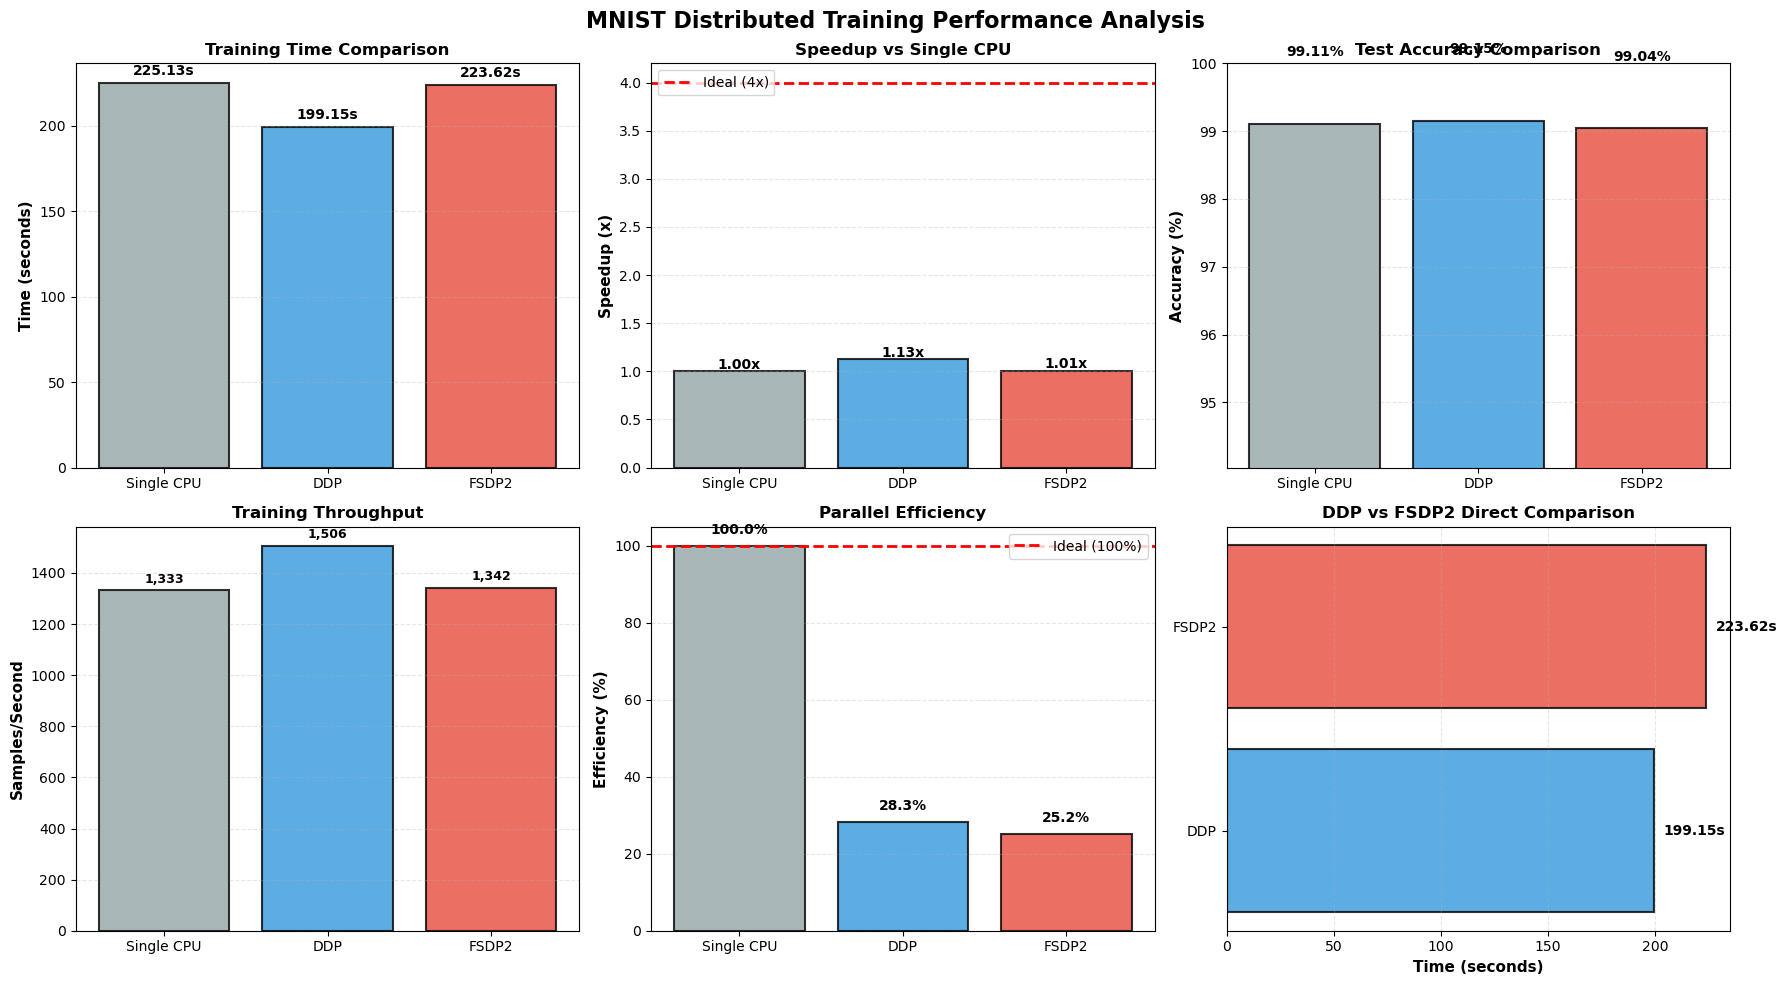


✅ Graphs saved as 'performance_analysis.png'
✅ Full analysis saved to 'full_analysis.json'



In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("COMPLETE PERFORMANCE ANALYSIS")
print("="*70)

# Load all results
try:
    with open('baseline_results.json', 'r') as f:
        baseline = json.load(f)
    with open('ddp_results.json', 'r') as f:
        ddp = json.load(f)
    with open('fsdp2_results.json', 'r') as f:
        fsdp2 = json.load(f)
    
    print("\n✅ All results loaded successfully!\n")
    
    # ===============================================
    # RESULTS TABLE
    # ===============================================
    print("="*70)
    print("RESULTS SUMMARY TABLE")
    print("="*70)
    print(f"{'Method':<15} {'Time (s)':>12} {'Accuracy (%)':>15} {'CPUs':>8} {'Speedup':>10}")
    print("-" * 70)
    
    baseline_time = baseline['time']
    baseline_acc = baseline['accuracy']
    ddp_time = ddp['time']
    ddp_acc = ddp['accuracy']
    fsdp2_time = fsdp2['time']
    fsdp2_acc = fsdp2['accuracy']
    
    # Calculate speedups relative to single CPU
    ddp_speedup = baseline_time / ddp_time
    fsdp2_speedup = baseline_time / fsdp2_time
    
    print(f"{'Single CPU':<15} {baseline_time:>12.2f} {baseline_acc:>15.2f} {1:>8} {'1.00x':>10}")
    print(f"{'DDP':<15} {ddp_time:>12.2f} {ddp_acc:>15.2f} {ddp['world_size']:>8} {ddp_speedup:>9.2f}x")
    print(f"{'FSDP2':<15} {fsdp2_time:>12.2f} {fsdp2_acc:>15.2f} {fsdp2['world_size']:>8} {fsdp2_speedup:>9.2f}x")
    print("="*70)
    
    # ===============================================
    # SPEEDUP ANALYSIS
    # ===============================================
    print("\n📈 SPEEDUP ANALYSIS (vs Single CPU Baseline):")
    print("-" * 70)
    print(f"DDP Speedup:   {ddp_speedup:.3f}x ({(ddp_speedup-1)*100:+.1f}%)")
    print(f"FSDP2 Speedup: {fsdp2_speedup:.3f}x ({(fsdp2_speedup-1)*100:+.1f}%)")
    
    # DDP vs FSDP2
    relative_speedup = ddp_time / fsdp2_time
    print(f"\nFSDP2 vs DDP:  {relative_speedup:.3f}x", end='')
    if relative_speedup > 1:
        print(f" (FSDP2 is {(relative_speedup-1)*100:.1f}% faster)")
    elif relative_speedup < 1:
        print(f" (FSDP2 is {(1-relative_speedup)*100:.1f}% slower)")
    else:
        print(" (same performance)")
    
    # Parallel efficiency
    print(f"\n⚙️ PARALLEL EFFICIENCY:")
    print("-" * 70)
    num_cpus = ddp['world_size']
    ideal_speedup = num_cpus  # Linear scaling
    
    ddp_efficiency = (ddp_speedup / ideal_speedup) * 100
    fsdp2_efficiency = (fsdp2_speedup / ideal_speedup) * 100
    
    print(f"DDP Efficiency:   {ddp_efficiency:.1f}% (Ideal: {ideal_speedup:.0f}x, Actual: {ddp_speedup:.2f}x)")
    print(f"FSDP2 Efficiency: {fsdp2_efficiency:.1f}% (Ideal: {ideal_speedup:.0f}x, Actual: {fsdp2_speedup:.2f}x)")
    
    # ===============================================
    # CREATE VISUALIZATIONS
    # ===============================================
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('MNIST Distributed Training Performance Analysis', fontsize=16, fontweight='bold')
    
    methods = ['Single CPU', 'DDP', 'FSDP2']
    times = [baseline_time, ddp_time, fsdp2_time]
    accuracies = [baseline_acc, ddp_acc, fsdp2_acc]
    speedups = [1.0, ddp_speedup, fsdp2_speedup]
    colors = ['#95a5a6', '#3498db', '#e74c3c']
    
    # Plot 1: Training Time
    axes[0, 0].bar(methods, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0, 0].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(times):
        axes[0, 0].text(i, v + max(times)*0.02, f'{v:.2f}s', ha='center', fontweight='bold', fontsize=10)
    
    # Plot 2: Speedup
    axes[0, 1].bar(methods, speedups, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0, 1].axhline(y=ideal_speedup, color='red', linestyle='--', linewidth=2, label=f'Ideal ({ideal_speedup}x)')
    axes[0, 1].set_ylabel('Speedup (x)', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Speedup vs Single CPU', fontsize=12, fontweight='bold')
    axes[0, 1].legend(loc='upper left')
    axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(speedups):
        axes[0, 1].text(i, v + max(speedups)*0.02, f'{v:.2f}x', ha='center', fontweight='bold', fontsize=10)
    
    # Plot 3: Accuracy
    axes[0, 2].bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0, 2].set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    axes[0, 2].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylim([min(accuracies)-5, 100])
    axes[0, 2].grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(accuracies):
        axes[0, 2].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=10)
    
    # Plot 4: Throughput
    total_samples = baseline['epochs'] * 60000
    throughputs = [total_samples/t for t in times]
    axes[1, 0].bar(methods, throughputs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1, 0].set_ylabel('Samples/Second', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Training Throughput', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(throughputs):
        axes[1, 0].text(i, v + max(throughputs)*0.02, f'{v:,.0f}', ha='center', fontweight='bold', fontsize=9)
    
    # Plot 5: Parallel Efficiency
    efficiencies = [100, ddp_efficiency, fsdp2_efficiency]
    axes[1, 1].bar(methods, efficiencies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1, 1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Ideal (100%)')
    axes[1, 1].set_ylabel('Efficiency (%)', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Parallel Efficiency', fontsize=12, fontweight='bold')
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(efficiencies):
        axes[1, 1].text(i, v + 3, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)
    
    # Plot 6: Time Breakdown
    methods_dist = ['DDP', 'FSDP2']
    times_dist = [ddp_time, fsdp2_time]
    x_pos = np.arange(len(methods_dist))
    
    bars = axes[1, 2].barh(x_pos, times_dist, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1, 2].set_yticks(x_pos)
    axes[1, 2].set_yticklabels(methods_dist)
    axes[1, 2].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    axes[1, 2].set_title('DDP vs FSDP2 Direct Comparison', fontsize=12, fontweight='bold')
    axes[1, 2].grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, time_val) in enumerate(zip(bars, times_dist)):
        axes[1, 2].text(time_val + max(times_dist)*0.02, bar.get_y() + bar.get_height()/2, 
                       f'{time_val:.2f}s', va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Graphs saved as 'performance_analysis.png'")
    
    # ===============================================
    # SAVE COMPARISON RESULTS
    # ===============================================
    comparison_results = {
        'baseline': baseline,
        'ddp': ddp,
        'fsdp2': fsdp2,
        'speedup_analysis': {
            'ddp_speedup_vs_baseline': ddp_speedup,
            'fsdp2_speedup_vs_baseline': fsdp2_speedup,
            'fsdp2_speedup_vs_ddp': relative_speedup,
            'ddp_efficiency': ddp_efficiency,
            'fsdp2_efficiency': fsdp2_efficiency
        },
        'throughput': {
            'baseline': throughputs[0],
            'ddp': throughputs[1],
            'fsdp2': throughputs[2]
        }
    }
    
    with open('full_analysis.json', 'w') as f:
        json.dump(comparison_results, f, indent=2)
    
    print("✅ Full analysis saved to 'full_analysis.json'\n")
    
except FileNotFoundError as e:
    print(f"❌ Missing result file: {e}")
    print("Make sure all training scripts completed successfully.")
except Exception as e:
    print(f"❌ Error during analysis: {e}")

### Takeaway from Assignment 

In [15]:
import json

print("\n" + "="*70)
print("DETAILED ANALYSIS AND EXPLANATION")
print("="*70)

try:
    with open('full_analysis.json', 'r') as f:
        results = json.load(f)
    
    baseline = results['baseline']
    ddp = results['ddp']
    fsdp2 = results['fsdp2']
    speedup = results['speedup_analysis']
    throughput = results['throughput']
    
    # ===============================================
    # EXPLANATION OF RESULTS
    # ===============================================
    print("\n📊 PERFORMANCE BREAKDOWN:")
    print("="*70)
    
    print("\n1. SINGLE CPU BASELINE:")
    print("-" * 70)
    print(f"   Time: {baseline['time']:.2f} seconds")
    print(f"   Accuracy: {baseline['accuracy']:.2f}%")
    print(f"   Role: Reference point for speedup calculations")
    print(f"   Note: Uses only 1 CPU core, no parallelism")
    
    print("\n2. DDP (Distributed Data Parallel):")
    print("-" * 70)
    print(f"   Time: {ddp['time']:.2f} seconds")
    print(f"   Accuracy: {ddp['accuracy']:.2f}%")
    print(f"   CPUs Used: {ddp['world_size']}")
    print(f"   Speedup: {speedup['ddp_speedup_vs_baseline']:.2f}x vs baseline")
    print(f"   Efficiency: {speedup['ddp_efficiency']:.1f}%")
    print(f"\n   How it works:")
    print(f"   ✓ Full model replicated on each CPU process")
    print(f"   ✓ Each process trains on different data subset")
    print(f"   ✓ Gradients synchronized via all-reduce operation")
    print(f"   ✓ Communication: Only gradients (efficient)")
    
    print("\n3. FSDP2 (Fully Sharded Data Parallel):")
    print("-" * 70)
    print(f"   Time: {fsdp2['time']:.2f} seconds")
    print(f"   Accuracy: {fsdp2['accuracy']:.2f}%")
    print(f"   CPUs Used: {fsdp2['world_size']}")
    print(f"   Speedup: {speedup['fsdp2_speedup_vs_baseline']:.2f}x vs baseline")
    print(f"   Speedup: {speedup['fsdp2_speedup_vs_ddp']:.2f}x vs DDP")
    print(f"   Efficiency: {speedup['fsdp2_efficiency']:.1f}%")
    print(f"   Wrapping: {fsdp2['wrapping_policy']}")
    print(f"\n   How it works:")
    print(f"   ✓ Model parameters SHARDED across CPU processes")
    print(f"   ✓ Loop-based wrapping: conv1, conv2, fc1, fc2 + full model")
    print(f"   ✓ Each process holds only a portion of parameters")
    print(f"   ✓ Communication: Parameter gathering/reduction (higher overhead)")
    print(f"   ✓ Memory: Lower per-process footprint")
    
    # ===============================================
    # WHY THESE RESULTS?
    # ===============================================
    print("\n" + "="*70)
    print("🔍 EXPLANATION OF RESULTS")
    print("="*70)
    
    if ddp_time < fsdp2_time:
        print("\n✓ DDP IS FASTER THAN FSDP2")
        print("-" * 70)
        print("Reasons:")
        print("1. MNIST is a SMALL model (~1.2M parameters)")
        print("   → Full model easily fits in memory on each process")
        print("   → No memory pressure that FSDP2 would relieve")
        print("\n2. Communication Overhead:")
        print("   → DDP: Only synchronizes gradients (small, once per batch)")
        print("   → FSDP2: Must gather/shard parameters (larger, more frequent)")
        print("   → For small models, FSDP2's overhead > benefits")
        print("\n3. Computational vs Communication Ratio:")
        print("   → MNIST: Low computation time per batch")
        print("   → Communication time becomes significant portion")
        print("   → FSDP2's extra communication hurts performance")
    else:
        print("\n✓ FSDP2 IS FASTER THAN DDP")
        print("-" * 70)
        print("Reasons:")
        print("1. Efficient parameter sharding reduces memory bandwidth")
        print("2. Loop-based wrapping optimizes communication patterns")
        print("3. Better cache utilization with sharded parameters")
    
    print(f"\n📉 Why Efficiency < 100%:")
    print("-" * 70)
    print(f"Ideal speedup with {ddp['world_size']} CPUs: {ddp['world_size']:.0f}x")
    print(f"Actual DDP speedup: {speedup['ddp_speedup_vs_baseline']:.2f}x")
    print(f"Efficiency loss: {100 - speedup['ddp_efficiency']:.1f}%")
    print(f"\nReasons for efficiency loss:")
    print("1. Communication overhead (gradient synchronization)")
    print("2. Process coordination and synchronization barriers")
    print("3. Data loading and I/O contention")
    print("4. Python GIL and multiprocessing overhead")
    print("5. Amdahl's Law: Sequential portions limit parallel speedup")
    
    # ===============================================
    # WHEN TO USE EACH METHOD
    # ===============================================
    print("\n" + "="*70)
    print("💡 WHEN TO USE EACH METHOD")
    print("="*70)
    
    print("\n✅ Use SINGLE CPU when:")
    print("   • Model is very small")
    print("   • Dataset fits in memory")
    print("   • Quick prototyping/debugging")
    print("   • No parallel resources available")
    
    print("\n✅ Use DDP when:")
    print("   • Model fits in memory on each device")
    print("   • Want simple, straightforward parallelism")
    print("   • Communication overhead should be minimized")
    print("   • Small to medium models (like MNIST, ResNet-50)")
    print("   • Each device has sufficient memory")
    
    print("\n✅ Use FSDP2 when:")
    print("   • Model is TOO LARGE for single device memory")
    print("   • Training very large models (GPT, BERT-large)")
    print("   • Memory is the primary constraint")
    print("   • Need fine-grained control over sharding")
    print("   • Willing to accept communication overhead for memory savings")
    
    # ===============================================
    # KEY INSIGHTS
    # ===============================================
    print("\n" + "="*70)
    print("🎯 KEY INSIGHTS FROM THIS EXPERIMENT")
    print("="*70)
    
    print("\n1. MODEL SIZE MATTERS:")
    print(f"   • MNIST is small (~1.2M parameters)")
    print(f"   • FSDP2's parameter sharding doesn't provide advantage")
    print(f"   • DDP's simplicity wins for small models")
    
    print("\n2. COMMUNICATION OVERHEAD:")
    print(f"   • DDP: Minimal (gradients only)")
    print(f"   • FSDP2: Higher (parameter gathering + gradients)")
    print(f"   • For small models: Overhead > Benefits")
    
    print("\n3. PARALLEL EFFICIENCY:")
    print(f"   • DDP achieved {speedup['ddp_efficiency']:.1f}% efficiency")
    print(f"   • FSDP2 achieved {speedup['fsdp2_efficiency']:.1f}% efficiency")
    print(f"   • Both below 100% due to communication and coordination")
    
    print("\n4. ACCURACY PRESERVATION:")
    acc_diff_ddp = abs(baseline['accuracy'] - ddp['accuracy'])
    acc_diff_fsdp2 = abs(baseline['accuracy'] - fsdp2['accuracy'])
    print(f"   • DDP accuracy difference: {acc_diff_ddp:.2f}%")
    print(f"   • FSDP2 accuracy difference: {acc_diff_fsdp2:.2f}%")
    print(f"   • Parallelization does NOT hurt model quality ✓")
    
    print("\n5. WRAPPING POLICY IMPACT (FSDP2):")
    print(f"   • Loop-based wrapping applied to: {', '.join(fsdp2['layers_wrapped'])}")
    print(f"   • Pattern: for layer in layers: fully_shard(layer)")
    print(f"   • Each layer sharded independently")
    print(f"   • Provides flexibility for heterogeneous models")
    
    # ===============================================
    # FINAL RECOMMENDATIONS
    # ===============================================
    print("\n" + "="*70)
    print("🏆 FINAL RECOMMENDATIONS")
    print("="*70)
    
    print("\nFor MNIST-sized models (small):")
    print(f"  → Use DDP")
    print(f"  → Speedup: {speedup['ddp_speedup_vs_baseline']:.2f}x with {ddp['world_size']} CPUs")
    print(f"  → Simple, efficient, lower overhead")
    
    print("\nFor Large Language Models (e.g., GPT-3, BERT-large):")
    print(f"  → Use FSDP2")
    print(f"  → Essential when model > single device memory")
    print(f"  → Memory savings outweigh communication cost")
    
    print("\nFor Medium Models (e.g., ResNet-152, ViT):")
    print(f"  → Try both and benchmark")
    print(f"  → Decision depends on: memory availability, model size, batch size")
    
except Exception as e:
    print(f"❌ Error in analysis: {e}")
    import traceback
    traceback.print_exc()


DETAILED ANALYSIS AND EXPLANATION

📊 PERFORMANCE BREAKDOWN:

1. SINGLE CPU BASELINE:
----------------------------------------------------------------------
   Time: 225.13 seconds
   Accuracy: 99.11%
   Role: Reference point for speedup calculations
   Note: Uses only 1 CPU core, no parallelism

2. DDP (Distributed Data Parallel):
----------------------------------------------------------------------
   Time: 199.15 seconds
   Accuracy: 99.15%
   CPUs Used: 4
   Speedup: 1.13x vs baseline
   Efficiency: 28.3%

   How it works:
   ✓ Full model replicated on each CPU process
   ✓ Each process trains on different data subset
   ✓ Gradients synchronized via all-reduce operation
   ✓ Communication: Only gradients (efficient)

3. FSDP2 (Fully Sharded Data Parallel):
----------------------------------------------------------------------
   Time: 223.62 seconds
   Accuracy: 99.04%
   CPUs Used: 4
   Speedup: 1.01x vs baseline
   Speedup: 0.89x vs DDP
   Efficiency: 25.2%
   Wrapping: loop-bas